In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import h5py 

In [97]:
u_data_path = "/data92/PeterChang/Dycore_data/PR50/u/PR50_500_20000day_u_6hourly.h5"
v_data_path = "/data92/PeterChang/Dycore_data/PR50/v/PR50_500_20000day_v_6hourly.h5"


In [132]:
last_day = 5000

with h5py.File(u_data_path, 'r') as u_file:
    u_data = u_file["u"][:last_day,:,32:]
with h5py.File(v_data_path, 'r') as v_file:
    v_data = v_file["v"][:last_day,:,32:]

In [133]:
u_data.shape

(5000, 20, 32, 128)

In [134]:
import sys 
sys = "/data92/PeterChang/1120_preprocessing/code"
from EOF import EOF

In [135]:
# Step 0. zonal mean and vertical integration u wind
u_zm = np.mean(u_data, axis=(1,3)) # pressure weighted didn't considered

# Step 1. weitghed u wind 
lat = np.linspace(0,90,32)
u_weight = u_zm * np.cos(np.deg2rad(lat)) ** 0.5

# Step 2. do EOF
n_components = np.shape(u_data)[2]
u_eof = EOF((u_weight,), n_components=n_components, field="1D")
u_eof.get()

EOF1 = u_eof.EOF[0]
PC1  = u_eof.PC[0]

In [136]:
print(EOF1.shape, PC1.shape)
print(EOF1.mean(), EOF1.std())
print(PC1.mean(), PC1.std())


(32,) (5000,)
0.0220849756106784 0.17539171546078144
1.3831164944967516 8.076412535684545


Text(0.5, 1.0, 'PC1 ')

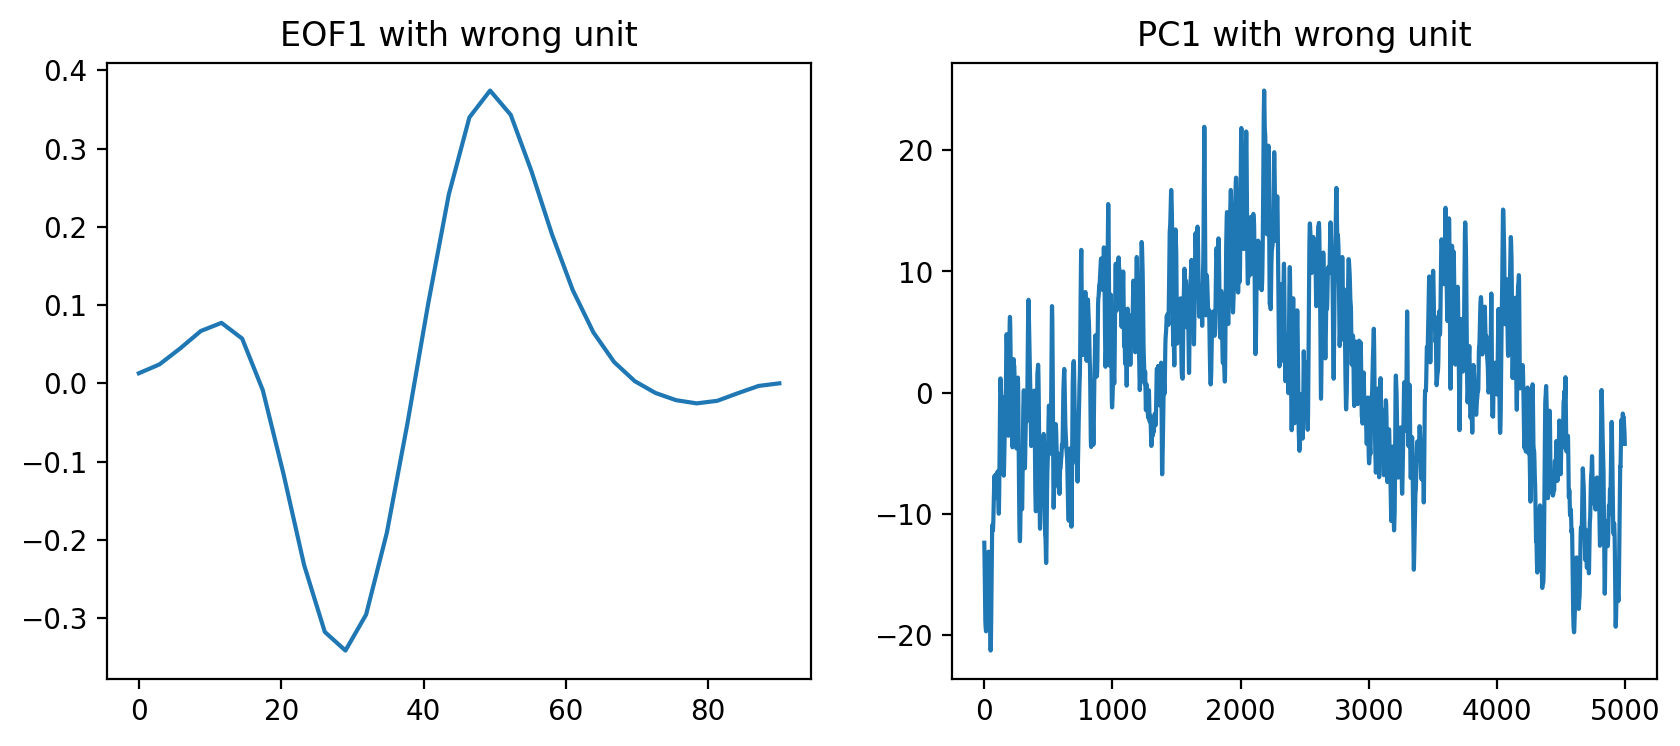

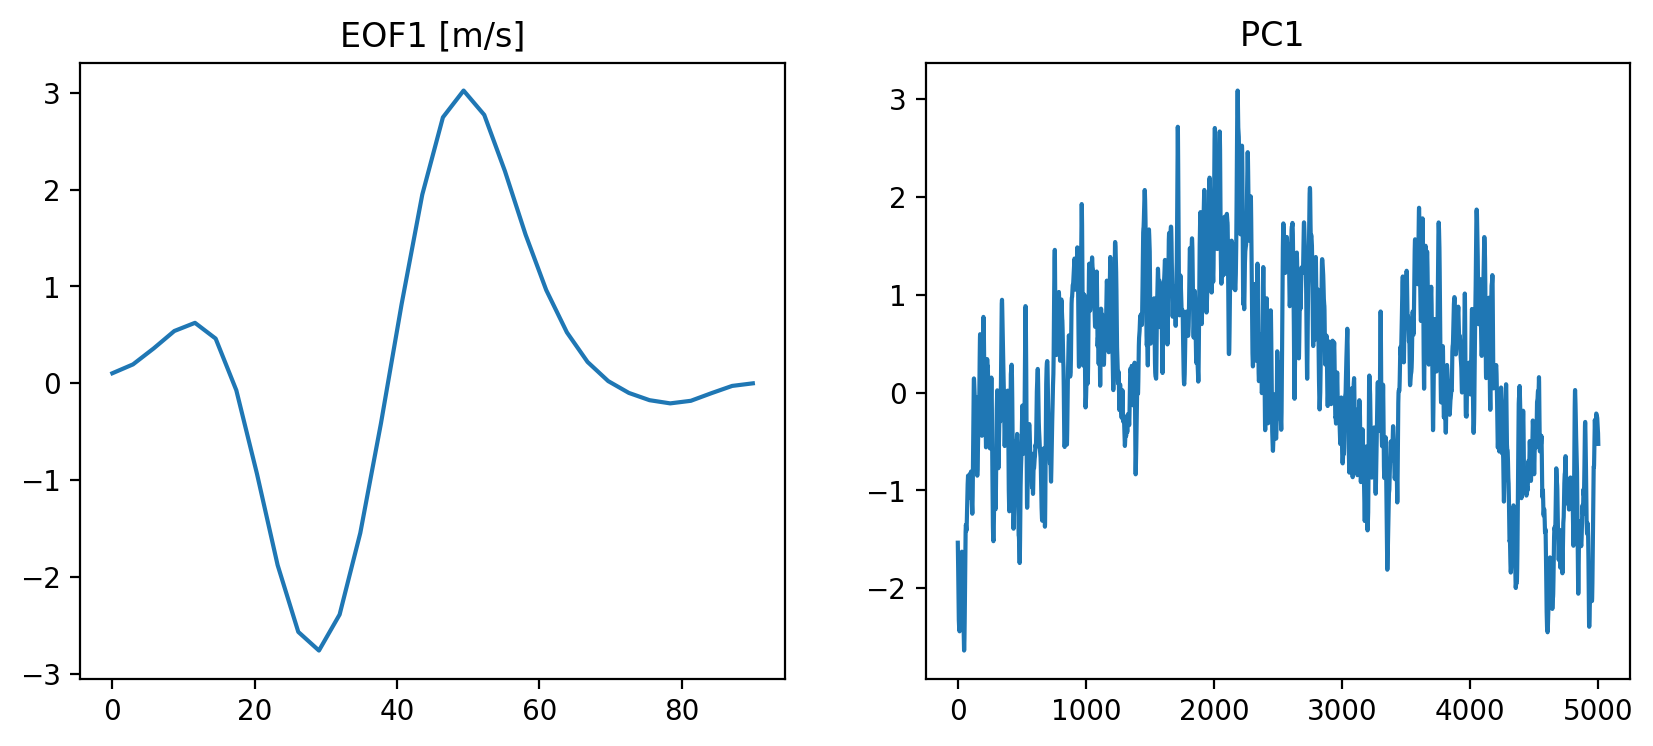

In [137]:
fig, axes = plt.subplots(1,2, figsize=(10,4), dpi=200.)
axes[0].plot(lat, EOF1) # [m/s] / PC1.std()
axes[1].plot(PC1) #  1 * PC1.std()

axes[0].set_title("EOF1 with wrong unit")
axes[1].set_title("PC1 with wrong unit")

fig, axes = plt.subplots(1,2, figsize=(10,4), dpi=200.)
axes[0].plot(lat, EOF1 * PC1.std()) # [m/s]
axes[1].plot(PC1 / PC1.std()) # 1

axes[0].set_title("EOF1 [m/s]")
axes[1].set_title("PC1 ")


# ${\partial \overline{u} \over \partial t} - (f + \zeta)\overline{v} = -{\partial \overline{u'v'} \over \partial y}  -  F$ 
## -> do vertical integration [  ] to all term, where $[\overline{v}] = 0 $
# ${\partial [\overline{u}] \over \partial t} = -{\partial [\overline{u'v'}] \over \partial y}  -  [F]$ 
## -> calculate EOF($[\overline{u}]$), whose unit is None!, and project every term to it
# ${\partial [\overline{u}] \over \partial t} | EOF([\overline{u}]) = -{\partial [\overline{u'v'}] \over \partial y} | EOF([\overline{u}]) -  [F] | EOF([\overline{u}]$)
# -> ${\partial z(t) \over \partial t} = m(t) - {z(t) \over \tau_z}$

In [164]:
# Prepareing EMF for calcualting m

def calculate_eddy_projection(u, v, lat, eof_pattern, EOF1, radius=6.371e6):
    """
    Calculates the normalized time series of eddy momentum flux convergence 
    projected onto a specific EOF pattern.

    Parameters:
    -----------
    u : np.ndarray
        Zonal velocity. Shape: (Time, Lat, Lon)
    v : np.ndarray
        Meridional velocity. Shape: (Time, Lat, Lon)
    lat : np.ndarray
        Latitude array in degrees. Shape: (Lat,)
    eof_pattern : np.ndarray
        The spatial EOF pattern to project onto. 
        Shape should match the sliced latitude domain (e.g., 32 points).
    radius : float
        Planet radius (default Earth: 6.371e6 meters).

    Returns:
    --------
    m_final : np.ndarray
        Normalized time series (Z-score). Shape: (Time,)
    """
    
    # 1. Calculate Eddy Momentum Flux (EMF = u'v')
    # --------------------------------------------
    # Calculate zonal means
    u_mean = np.mean(u, axis=-1, keepdims=True)
    v_mean = np.mean(v, axis=-1, keepdims=True)
    
    # Calculate eddies (deviations from zonal mean)
    u_prime = u - u_mean
    v_prime = v - v_mean
    
    # Zonal mean of the product of eddies
    emf = np.mean(u_prime * v_prime, axis=-1)  # Shape: (Time, Lat)
    emf_vm = emf.mean(axis=1)

    # 2. Calculate Convergence (dmdy)
    # --------------------------------------------
    # Convert lat to radians for geometric calculations
    phi = np.deg2rad(lat)
    cy = np.cos(phi)  # Cosine weights
    
    # Calculate weighting for angular momentum flux: EMF * cos^2(phi)
    # Note: We broadcast cy to shape (1, Lat) to multiply with emf (Time, Lat)
    weighted_emf = emf_vm * (cy[None, :] ** 2)
    
    # Calculate derivative with respect to latitude (phi)
    # np.gradient handles the boundaries (0 and -1) automatically
    d_weighted_dphi = np.gradient(weighted_emf, phi, axis=1)
    
    # Apply spherical convergence formula: -1/(a * cos^2(phi)) * d/dphi(...)
    dmdy = -1 * d_weighted_dphi / (radius * (cy[None, :] ** 2))

    # 3. Project onto EOF (Pattern Matching)
    # --------------------------------------------
    # We assume the EOF corresponds to the latter half of the latitudes 
    # (based on your snippet's `32:` slice).
    m = np.dot(dmdy, EOF1) / EOF1.dot(EOF1.T)

    # 4. Normalize
    # --------------------------------------------
    m_final = (m - np.mean(m)) / np.std(m)

    return m_final

In [165]:
m = calculate_eddy_projection(u_data[:], v_data[:], lat, 32, EOF1)

In [166]:
print(m.shape)

(5000,)


In [141]:
# Calculating z

In [142]:
z = PC1

In [143]:
PC1.shape

(5000,)